In [21]:
# naively implementing CNOT on dual-rail
from qutip import tensor, basis, Qobj
import numpy as np
from quantum_logical.basis import SNAILConcatWithAncilla
from quantum_logical.unitary_util import ImplicitUnitaryGate
from qiskit.circuit.library import HGate, CXGate, iSwapGate
from qiskit import QuantumCircuit
from weylchamber import c1c2c3
from qiskit.quantum_info import Operator
from qiskit import transpile

Load the dualrail encoding and convert HGate and CNOT gate into logical gates


In [22]:
# U = |g><0| + |e><1|
# transform computational into qutrit computational
op_ge = (basis(3, 0) * basis(2, 0).dag() + basis(3, 1) * basis(2, 1).dag()).full()
print(op_ge)

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]


In [23]:
# U = |e><0| + |f><1|
# transform computational into qutrit computational
op_ef = (basis(3, 1) * basis(2, 0).dag() + basis(3, 2) * basis(2, 1).dag()).full()
print(op_ef)

[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [24]:
# U = |g><0| + |f><1|
# transform Qiskit computational into gf transmon basis
op_gf = (basis(3, 0) * basis(2, 0).dag() + basis(3, 2) * basis(2, 1).dag()).full()
print(op_gf)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [25]:
encoding = SNAILConcatWithAncilla()
# U = |+++><0| + |---><1|
op = encoding.logical_basis.transform_operator.full()
# print(op)

In [7]:
# for 2 qubits
# U = |++++++><00| + |+++---><01| + |---+++><10| + |---><11|
print(np.kron(op, op))

[[ 0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j]
 ...
 [ 0.125+0.j  0.125+0.j -0.125+0.j -0.125+0.j]
 [ 0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j]
 [ 0.125+0.j -0.125+0.j -0.125+0.j  0.125-0.j]]


In [8]:
# A' = U @ A @ U^dag
new_op = op @ HGate().to_matrix() @ op.conj().T
# logical_h = ImplicitUnitaryGate(new_op) #qudit breaks UnitaryGate
logical_h = ImplicitUnitaryGate.create_unitary_from_implicit_operator(new_op)
# print(logical_h)

In [9]:
# A' = U @ A @ U^dag
new_op = np.kron(op, op) @ CXGate().to_matrix() @ np.kron(op, op).conj().T
logical_cnot = ImplicitUnitaryGate.create_unitary_from_implicit_operator(new_op)
print(np.real(logical_cnot))

[[ 1.00000000e+00  0.00000000e+00 -3.08148791e-33 ... -3.08148791e-33
   0.00000000e+00  3.08148791e-33]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.08148791e-33  0.00000000e+00  1.00000000e+00 ...  3.08148791e-33
   0.00000000e+00 -3.08148791e-33]
 ...
 [ 3.08148791e-33  0.00000000e+00 -3.08148791e-33 ...  9.37500000e-01
   0.00000000e+00  6.25000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-3.08148791e-33  0.00000000e+00  3.08148791e-33 ...  6.25000000e-02
   0.00000000e+00  9.37500000e-01]]


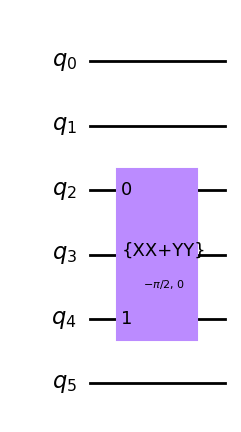

In [10]:
# explore basis gates in the encoding
# gates in the circuit will be applied to the gf transmon basis
N = 6

tensor_op = op_gf
for _ in range(N - 1):
    tensor_op = np.kron(op_gf, tensor_op)

qc = QuantumCircuit(6)
# YOUR GATE HERE
# qc.iswap(2,3)
qc.append(iSwapGate().power(1 / 2), [2, 4])
# qc.append(iSwapGate().power(1 / 8), [1, 4])
# qc.append(iSwapGate().power(1 / 8), [0, 3])
display(qc.draw("mpl"))

# what does this gate do on the encoding?
cz_op = Operator(qc).data

# first need to transform into gf basis
cz_op_gf = tensor_op @ cz_op @ tensor_op.conj().T

In [58]:
# A = U^dag @ A' @ U
new_op = np.kron(op, op).conj().T @ cz_op_gf @ np.kron(op, op)
logical_cnot = ImplicitUnitaryGate.create_unitary_from_implicit_operator(new_op)
print(logical_cnot)

# inspect the resulting logical 2Q gate
print(c1c2c3(logical_cnot))

[[ 1.00000000e+00+3.53553391e-01j -6.16297582e-33+5.95262989e-19j
   2.77555756e-17+0.00000000e+00j  6.16297582e-33+0.00000000e+00j]
 [-6.16297582e-33-5.95262989e-19j  1.00000000e+00-3.53553391e-01j
   6.16297582e-33+0.00000000e+00j  2.77555756e-17+0.00000000e+00j]
 [ 2.77555756e-17+0.00000000e+00j  6.16297582e-33+0.00000000e+00j
   1.00000000e+00-3.53553391e-01j -6.16297582e-33-5.95262989e-19j]
 [ 6.16297582e-33+0.00000000e+00j  2.77555756e-17+0.00000000e+00j
  -6.16297582e-33+5.95262989e-19j  1.00000000e+00+3.53553391e-01j]]
(0.2163469, 0.0, 0.0)


In [42]:
# I am not sure the following example works because an iswap between ge composed with an iswap between ef
# I find it reduces to an identity gate on the erasure encoding


def apply_gate_to_qutrits(gate, qutrit_positions, N):
    """
    Apply a specified gate to specified qutrits in a larger qutrit register.

    Parameters:
    - gate: The gate to be applied, as a matrix.
    - qutrit_positions: A list of the qutrits on which the gate should be applied.
    - N: The total number of qutrits in the system.

    Returns:
    - The resulting operation for the entire system.
    """
    # Start with an identity operation for the full system
    full_operation = np.eye(3**N, dtype=complex)

    # For simplicity, let's handle the 2-qutrit case first
    if len(qutrit_positions) == 2:
        # Compute the indices in the full operation matrix
        # where the gate should be inserted
        for i in range(3):
            for j in range(3):
                row = 3 * qutrit_positions[0] + i
                col = 3 * qutrit_positions[1] + j
                full_operation[row, col] = gate[i, j]
                # /tmp/ipykernel_343/1787588528.py:24: ComplexWarning: Casting complex values to real discards the imaginary part

    # TODO: Handle cases where len(qutrit_positions) > 2, if necessary

    return full_operation

In [64]:
iswap_ge = (
    np.kron(op_ge, op_ge) @ iSwapGate().to_matrix() @ np.kron(op_ge, op_ge).conj().T
)
iswap_ge = ImplicitUnitaryGate.create_unitary_from_implicit_operator(iswap_ge)
iswap_ef = (
    np.kron(op_ef, op_ef) @ iSwapGate().to_matrix() @ np.kron(op_ef, op_ef).conj().T
)
iswap_ef = ImplicitUnitaryGate.create_unitary_from_implicit_operator(iswap_ef)

# compose the two gates
iswap_ge_ef = iswap_ef @ iswap_ge

print("iswap_ge @ iswap_ef")
print(iswap_ge_ef)

# Apply iswap_ge_ef to qutrits 2 and 3 of a 6-qutrit system
resulting_gate = apply_gate_to_qutrits(iswap_ge_ef, [0, 5], 6)
print(resulting_gate.shape)

# convert back to computational
print("project back to computational basis")
new_op = np.kron(op, op).conj().T @ resulting_gate @ np.kron(op, op)
print(new_op)

# inspect the resulting logical 2Q gate
print(c1c2c3(new_op))

iswap_ge @ iswap_ef
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
(729, 729)
project back to computational basis
[[ 1.00000000e+00+0.j -6.16297582e-33+0.j  1.38777878e-17+0.j
   6.16297582e-33+0.j]
 [-6.16297582e-33+0.j  1.00000000e+00+0.j  6.16297582e-33+0.j
   1.38777878e-17+0.j]
 [ 1.38777878e-17+0.j  6.16297582e-33+0.j  1.00000000e+00+0.j
  -6.16297582e-33+0.j]
 [ 6.16297582e-33+0.j  1.38777878e-17+0.j -6.16297582e-33+0.j
   1.00000000e+00+0.j

Current speculative basis gate is 5 wave, medium murky.
Definitely in the Hamiltonian, but not ideal since expensive (and speed limits)

Issue is likely will be slower, so we don't know if it will buy us an advantage.
Needs to buy advantage in gate counts if will be a slower basis.

In order to not have 5 wave, advice is to not be afraid of leaving the code space.
Is fine as long as error rates

# alternative mechansim:

|fg> to |ee>, then |ee> to |gf> (two-step process consisting of 3 wave gates)
See fig1: https://arxiv.org/pdf/2302.06707.pdf

# XXX my notation of ladder operators should be same as how Mingkang does it

my operators are implicitly truncated, but a is really infinite Hilbert space
so a is really a_ge, etc

# refactor code, so operators are the H instead of the U

use U=e^-iHt

# TODO adding the phase terms to the operators
